# Binary Classification of Machine Failures

This notebook is for a Kaggle competition from https://www.kaggle.com/competitions/playground-series-s3e17/data

In [28]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Modelling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Experiment tracking
import mlflow

In [29]:
train_data = "data/train.csv"
test_data = "data/test.csv"
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
target_col = "Machine failure"

In [30]:
train_df.shape, test_df.shape

((136429, 14), (90954, 13))

In [31]:
train_df.columns

Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [32]:
train_df.describe()

,id,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,299.862776,309.941070,1520.331110,40.348643,104.408901,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,1.862247,1.385173,138.736632,8.502229,63.965040,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,295.300000,305.800000,1181.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,298.300000,308.700000,1432.000000,34.600000,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,300.000000,310.000000,1493.000000,40.400000,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,301.200000,310.900000,1580.000000,46.100000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,304.400000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
train_df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [34]:
train_df[target_col].unique()

array([0, 1])

In [35]:
# Data is unbalanced
train_df.groupby([target_col]).id.count()

Machine failure
0    134281
1      2148
Name: id, dtype: int64

[]

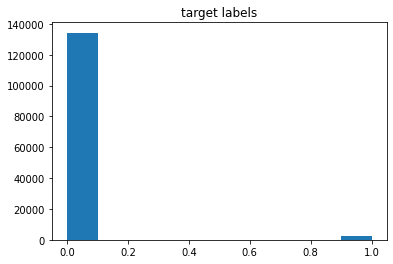

In [36]:
plt.hist(train_df[target_col].tolist())
plt.title("target labels")
plt.plot()

### Missing value check

In [37]:
# Check missing values
train_df.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

### Correlation check

In [38]:
# Check correlations among features
col_num = train_df.columns.drop(['id', 'Product ID', 'Type'])
corr = train_df[col_num.drop(target_col)].corr(method='pearson', min_periods=1, numeric_only=False)
corr

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
Air temperature [K],1.000000,0.856080,0.016545,-0.006773,0.016994,0.003826,0.100454,0.007967,0.007842,0.004815
Process temperature [K],0.856080,1.000000,0.011263,-0.006298,0.012777,0.004459,0.041454,0.003871,0.005337,0.004399
Rotational speed [rpm],0.016545,0.011263,1.000000,-0.779394,0.003983,-0.005765,-0.081996,0.053948,-0.061376,-0.003410
Torque [Nm],-0.006773,-0.006298,-0.779394,1.000000,-0.003148,0.012983,0.100773,0.050289,0.108765,0.007986
Tool wear [min],0.016994,0.012777,0.003983,-0.003148,1.000000,0.046470,0.011709,0.007624,0.063604,-0.002071
TWF,0.003826,0.004459,-0.005765,0.012983,0.046470,1.000000,0.010145,0.039927,0.036041,0.002044
HDF,0.100454,0.041454,-0.081996,0.100773,0.011709,0.010145,1.000000,0.046680,0.067149,0.000885
PWF,0.007967,0.003871,0.053948,0.050289,0.007624,0.039927,0.046680,1.000000,0.090016,0.000827
OSF,0.007842,0.005337,-0.061376,0.108765,0.063604,0.036041,0.067149,0.090016,1.000000,-0.000539
RNF,0.004815,0.004399,-0.003410,0.007986,-0.002071,0.002044,0.000885,0.000827,-0.000539,1.000000


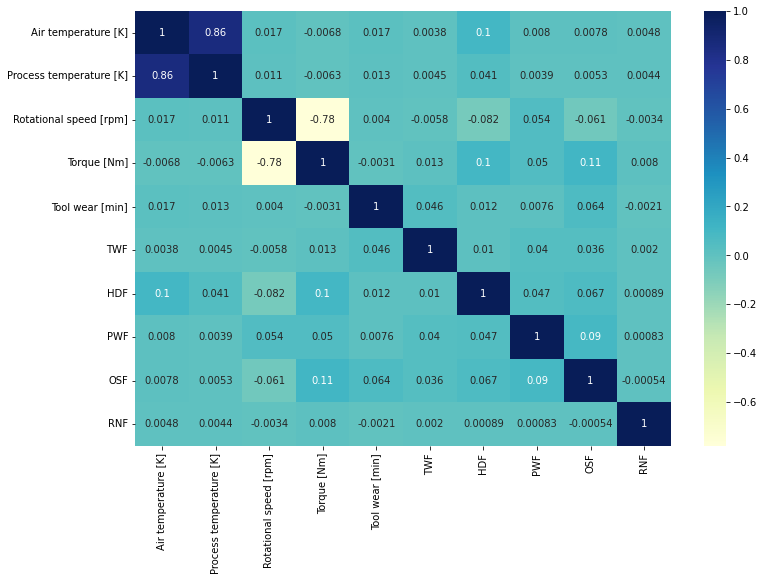

In [39]:
plt.figure(figsize = (12, 8))
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

You can see the correlation between Process temperature and Air temperature, as well as Torque and Rotational speed. Let's plot them on scatter plot.

[]

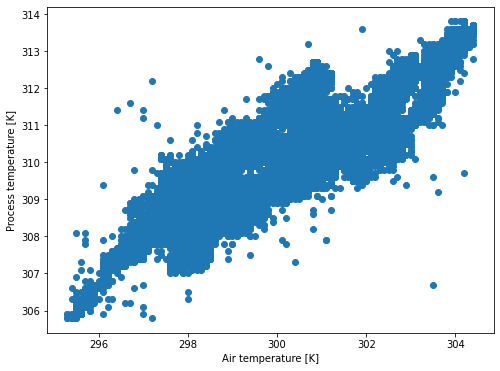

In [40]:
plt.figure(figsize = (8, 6))
x = train_df['Air temperature [K]'].tolist()
y = train_df['Process temperature [K]'].tolist()
plt.scatter(x, y)
plt.xlabel('Air temperature [K]')
plt.ylabel('Process temperature [K]')
plt.plot()

[]

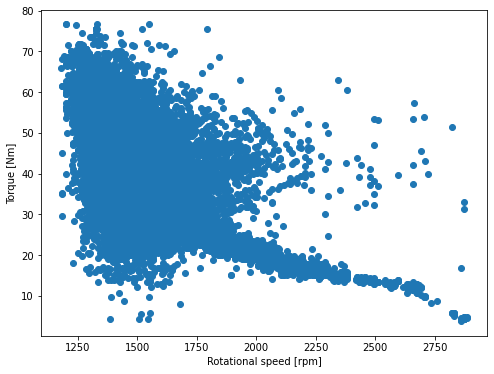

In [41]:
plt.figure(figsize = (8, 6))
x = train_df['Rotational speed [rpm]'].tolist()
y = train_df['Torque [Nm]'].tolist()
plt.scatter(x, y)
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.plot()

### Statistical Test

In [42]:
print("Result of t-test with the target variable 'Machine failure'\n")
for col in col_num.drop(target_col):
    res = ttest_ind(train_df[col], train_df[target_col])
    print(f"{col}: ", res)

Result of t-test with the target variable 'Machine failure'

Air temperature [K]:  Ttest_indResult(statistic=59340.01261160426, pvalue=0.0)
Process temperature [K]:  Ttest_indResult(statistic=82311.32554067486, pvalue=0.0)
Rotational speed [rpm]:  Ttest_indResult(statistic=4047.5825115998837, pvalue=0.0)
Torque [Nm]:  Ttest_indResult(statistic=1751.9973234431986, pvalue=0.0)
Tool wear [min]:  Ttest_indResult(statistic=602.8119886940104, pvalue=0.0)
TWF:  Ttest_indResult(statistic=-40.14327232179999, pvalue=0.0)
HDF:  Ttest_indResult(statistic=-27.218316577712752, pvalue=6.5226209865866e-163)
PWF:  Ttest_indResult(statistic=-36.8619325471856, pvalue=1.0191987504514202e-296)
OSF:  Ttest_indResult(statistic=-31.224401874723775, pvalue=1.1872232521945708e-213)
RNF:  Ttest_indResult(statistic=-37.39170665182456, pvalue=3.184022653238172e-305)


null hypothesis : the two(failure and non-failure) are from the same population.

p-value smaller than 0.05 means that there is a statistically significant difference between the two groups.

# Training models

In [43]:
# train test split
train, valid = train_test_split(train_df, test_size=0.3)
X_train = train.drop(target_col, axis=1)
y_train = train[target_col]
X_valid = valid.drop(target_col, axis=1)
y_valid = valid[target_col]

In [44]:
X_train.shape, X_valid.shape

((95500, 13), (40929, 13))

In [18]:
numeric_features = col_num.drop(target_col)
numeric_transformer = StandardScaler()
categorical_features = ['Type']
categorical_transformer = OneHotEncoder()

In [19]:
processor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [20]:
model = RandomForestClassifier()

In [21]:
# Defining pipeline
pipe = Pipeline([
    ('processor', processor), 
    ('classifier', model)
])

In [22]:
param_grid = {
    "classifier__n_estimators": [30, 60, 100],
    'classifier__max_depth': [5, 10, 20]
}

In [23]:
grid_search = GridSearchCV(pipe, param_grid, cv=5)

In [24]:
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 30}
Best cross-validated score: 0.9961570680628272


In [26]:
pred = grid_search.predict(X_valid)
fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.8782244634858333

In [45]:
mlflow.set_experiment("my_kaggle_experiment")

2023/09/06 22:36:31 INFO mlflow.tracking.fluent: Experiment with name 'my_kaggle_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/ubuntu/Binary_Classification_of_Machine_Failures/mlruns/134646236454958879', creation_time=1694039791949, experiment_id='134646236454958879', last_update_time=1694039791949, lifecycle_stage='active', name='my_kaggle_experiment', tags={}>

In [46]:
with mlflow.start_run(run_name="RandomForest_run"):
    
    numeric_features = col_num.drop(target_col)
    numeric_transformer = StandardScaler()
    categorical_features = ['Type']
    categorical_transformer = OneHotEncoder()

    processor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )

    model = RandomForestClassifier()
    pipe = Pipeline([
        ('processor', processor), 
        ('classifier', model)
    ])

    param_grid = {
        "classifier__n_estimators": [30, 60, 100],
        'classifier__max_depth': [5, 10, 20]
    }

    grid_search = GridSearchCV(pipe, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    # Logging the best parameters and cross-validated score
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("best_cv_score", grid_search.best_score_)

    pred = grid_search.predict(X_valid)

    # Calculate and log AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred, pos_label=1)
    auc_score = metrics.auc(fpr, tpr)
    mlflow.log_metric("auc", auc_score)

    # Log the trained model (optional)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "RandomForest_model")

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)
print("AUC:", auc_score)


Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best cross-validated score: 0.996261780104712
AUC: 0.8787598716312844
